# Visualizing HSIC Measures

In [1]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# toy datasets
from data.toy import generate_dependence_data

# Kernel Dependency measure
from models.dependence import HSIC
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

# RBIG IT measures
# Plotting
from visualization.distribution import plot_scorer_mi
from models.ite_algorithms import run_rbig_models

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_style("dark")
sns.set_context("poster")
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

In [2]:
fig_path = "/home/emmanuel/projects/2019_hsic_align/results/figures/distribution_experiment/"

In [3]:
save_path   = f'{cwd}/../../results/distribution/'
save_name   = 'dist_v3_medians'

cols = [
    'dataset', 
    'trial', 
    'samples', 
    'dimensions', 
    'dof', 
    'gamma_method', 
    'gamma_init',
    'scorer', 
    'hsic_value',
    'mi_value'
]

results_df = pd.read_csv(f"{save_path}{save_name}.csv")

In [4]:
results_df.tail()

Unnamed: 0 dataset  dimensions   dof    gamma_init gamma_method  \
82495       82495   gauss       100.0   7.0  3.129779e-07  median_s100   
82496       82496   gauss       100.0   8.0  3.302133e-07  median_s100   
82497       82497   gauss       100.0   9.0  3.489629e-07  median_s100   
82498       82498   gauss       100.0  10.0  3.692956e-07  median_s100   
82499       82499   gauss       100.0  11.0  3.915986e-07  median_s100   

       hsic_value  mi_value  samples scorer  trial  
82495    0.946841  1.904172   5000.0   ctka    5.0  
82496    0.962541  2.463445   5000.0   ctka    5.0  
82497    0.973092  3.332690   5000.0   ctka    5.0  
82498    0.980514  4.828360   5000.0   ctka    5.0  
82499    0.985921  7.938746   5000.0   ctka    5.0

In [5]:
results_df = results_df[cols]
results_df.tail()

dataset  trial  samples  dimensions   dof gamma_method    gamma_init  \
82495   gauss    5.0   5000.0       100.0   7.0  median_s100  3.129779e-07   
82496   gauss    5.0   5000.0       100.0   8.0  median_s100  3.302133e-07   
82497   gauss    5.0   5000.0       100.0   9.0  median_s100  3.489629e-07   
82498   gauss    5.0   5000.0       100.0  10.0  median_s100  3.692956e-07   
82499   gauss    5.0   5000.0       100.0  11.0  median_s100  3.915986e-07   

      scorer  hsic_value  mi_value  
82495   ctka    0.946841  1.904172  
82496   ctka    0.962541  2.463445  
82497   ctka    0.973092  3.332690  
82498   ctka    0.980514  4.828360  
82499   ctka    0.985921  7.938746

In [6]:
res_samples = results_df['samples'].unique().tolist()
res_dists = results_df['dataset'].unique().tolist()
res_dimensions = results_df['dimensions'].unique().tolist()
res_scorer = results_df['scorer'].unique().tolist()
res_gamma = results_df['gamma_method'].unique().tolist()

## Figure I - Gaussian Distribution

In [7]:
results_gaussian = results_df[results_df['dataset'] == 'gauss']

results_gaussian.tail()

dataset  trial  samples  dimensions   dof gamma_method    gamma_init  \
82495   gauss    5.0   5000.0       100.0   7.0  median_s100  3.129779e-07   
82496   gauss    5.0   5000.0       100.0   8.0  median_s100  3.302133e-07   
82497   gauss    5.0   5000.0       100.0   9.0  median_s100  3.489629e-07   
82498   gauss    5.0   5000.0       100.0  10.0  median_s100  3.692956e-07   
82499   gauss    5.0   5000.0       100.0  11.0  median_s100  3.915986e-07   

      scorer  hsic_value  mi_value  
82495   ctka    0.946841  1.904172  
82496   ctka    0.962541  2.463445  
82497   ctka    0.973092  3.332690  
82498   ctka    0.980514  4.828360  
82499   ctka    0.985921  7.938746

### 1. Take the Mean wrt to the experimental params

In [8]:
def average_trials(res_df):
    # Take the average of the trials
    cols = res_df.columns.tolist()
#     cols.remove('trial')
#     cols.remove('value')
#     cols.remove('gamma')
    return res_df.groupby(cols).mean().drop('trial', axis=1).reset_index()

def variance_trials(res_df):
    # Take the average of the trials
    cols = res_df.columns.tolist()
    cols.remove('trial')
    return res_df.groupby(cols).std().reset_index().drop('trial', axis=1)

### II - Extract the fixed variables with labels

In [9]:
def plot_prepare(res_df, dataset='gauss'):
    
    # grab dataset attributes (fixed variables)
    d_dimensions = res_df['dimensions'].unique()
    n_samples = res_df['samples'].unique()
    dataset = res_df['dataset'].unique()  
    gamma_method = res_df['gamma_method'].unique()
    scorers = res_df['scorer'].unique().tolist()
    fixed_vars = {
        'dimensions':int(d_dimensions),
        'samples': int(n_samples),
        'gamma_method': gamma_method,
        'dataset': dataset,
        'scorer': scorers,
    }

    return res_df, fixed_vars

### Step III - Plot

In [10]:
def plot_gammas(res_df, fixed_vars, save=True):
    for iscore in res_df.groupby('scorer'):
        

                             
#         print(iscore[1].head())
        mean_results = iscore[1].groupby(['dataset', 'dimensions', 'scorer', 'dof', 'gamma_method']).median()
        std_results = iscore[1].groupby(['dataset', 'dimensions', 'scorer', 'dof', 'gamma_method']).std()
        mean_results['hsic_std'] = std_results['hsic_value'].values
        mean_results['mi_std'] = std_results['mi_value'].values
        mean_results = mean_results.reset_index().drop(columns=['scorer', 'trial', 'samples'])
        gamma_legend = mean_results['gamma_init'].unique()
#         print(mean_results.head(3))
#         break
#         print(mean_results.head())
        fig, ax = plt.subplots()
        pts = sns.scatterplot(
            x='hsic_value', 
            y='mi_value', 
            hue='gamma_method',
            data=mean_results, 
#             size='hsic_std',
#             sizes=(50,200),
            legend='brief',
            ax=ax, 
#             hue='gamma', 
#             hue_norm=matplotlib.colors.LogNorm(),
#             label=iscore[0].upper(),
            palette='Spectral'
        )
#         ax.legend(gamma_legend)
        ax.legend(prop={'size':9})
        ax.set_xlabel('Score')
        ax.set_ylabel(r'Mutual Information')
        ax.set_title(
            f"D: {int(fixed_vars['dimensions'])},"
            f" N: {fixed_vars['samples']},"
            f"{fixed_vars['dataset'][0]}, "
            f"{iscore[0].upper()}"
        )
        
        # set xlimits for KTA and CKTA
        if iscore[0] in ['ctka', 'tka'] and fixed_vars['dataset'][0] == 'gauss':
            ax.set_xlim([-0.1, 1.1])
        elif iscore[0] in ['hsic'] and fixed_vars['dataset'][0] == 'gauss':
            ax.set_xlim([-0.05, 0.5])
        # COLORBAR
#         norm = matplotlib.colors.LogNorm(mean_results.gamma.min(), mean_results.gamma.max())
#         sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
#         sm.set_array([])
#         pts.figure.colorbar(sm, label=r'RBF Bandwidth, $\gamma$')
        
        plt.show()
        if save:
            save_name = \
                f"{fixed_vars['dataset'][0]}_" + \
                f"{int(fixed_vars['samples'])}_" + \
                f"{int(fixed_vars['dimensions'])}_" + \
                f"{iscore[0].upper()}" + \
                ".png"

            fig.savefig(fig_path + save_name)
    return None

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


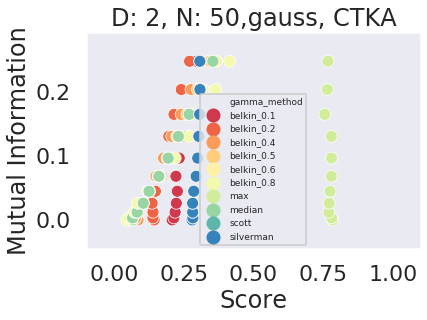

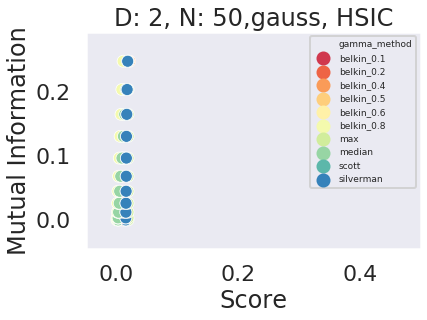

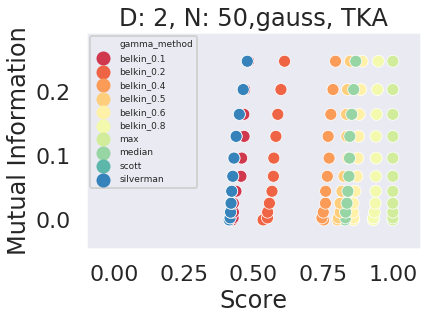

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


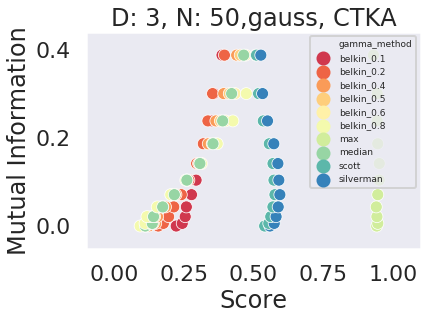

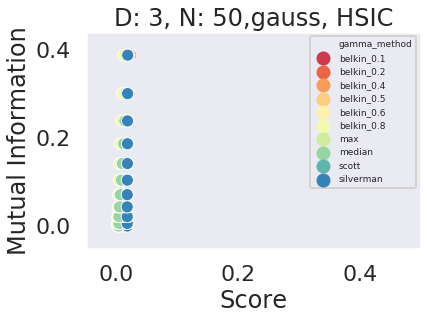

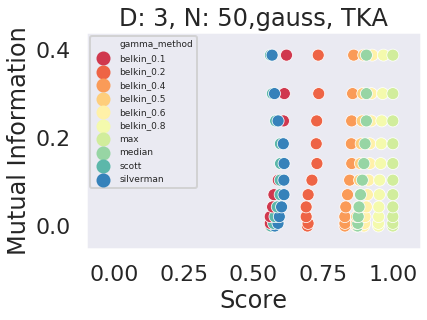

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


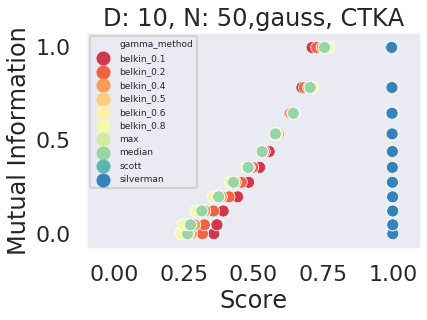

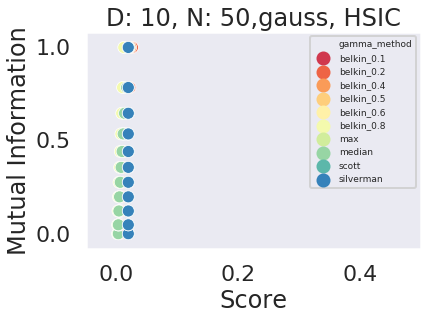

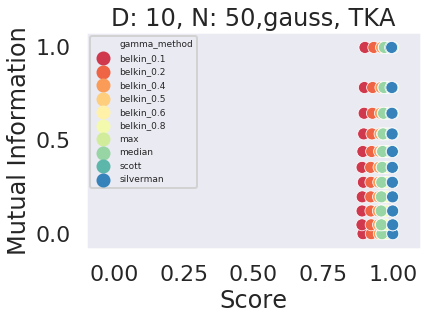

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


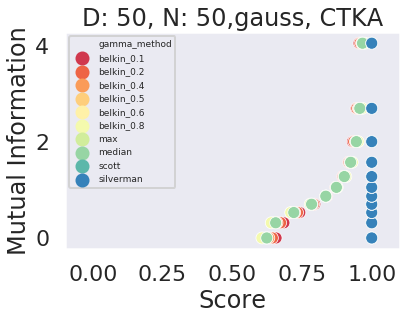

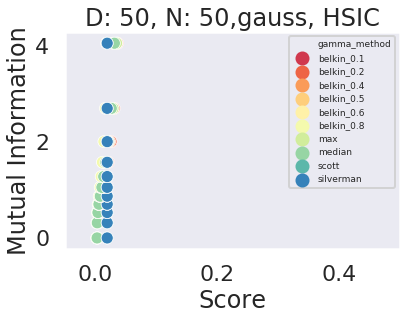

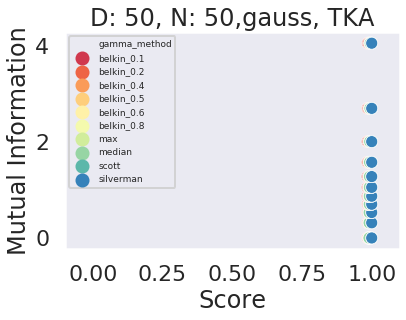

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


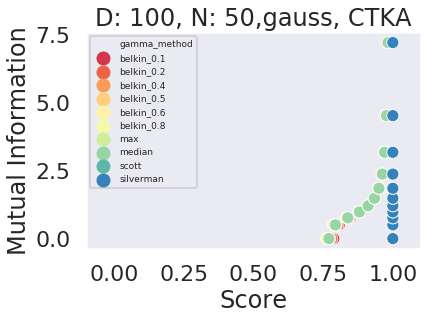

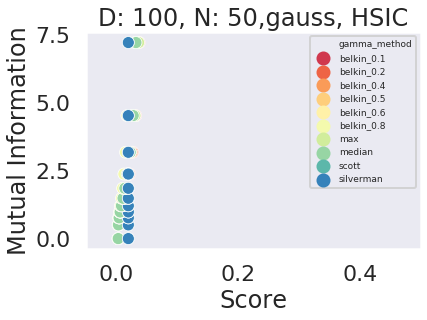

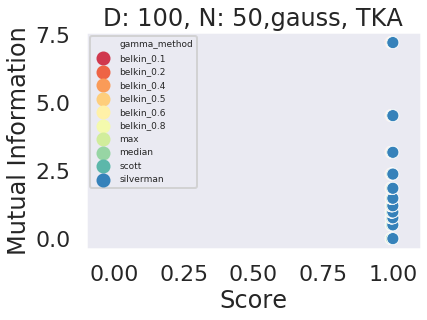

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


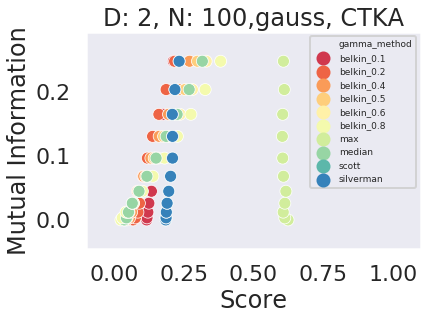

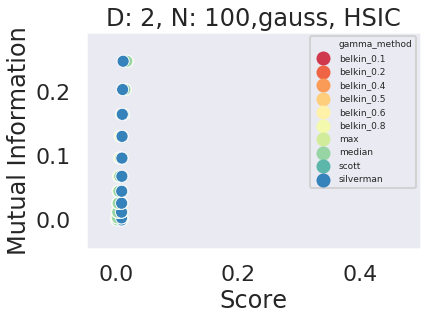

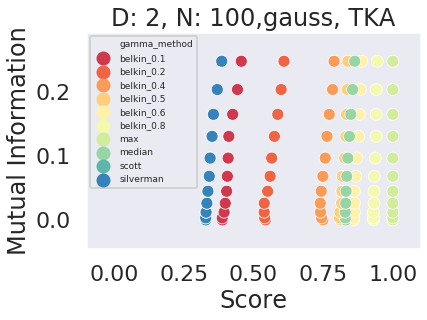

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


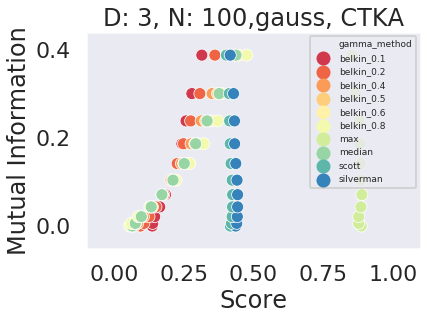

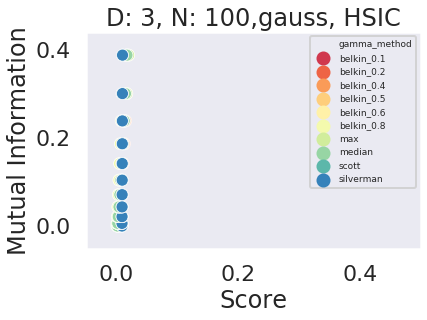

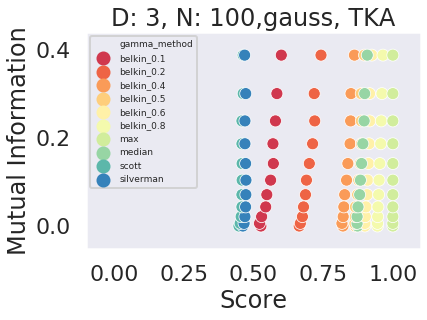

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


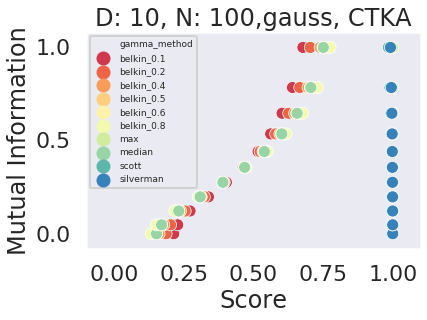

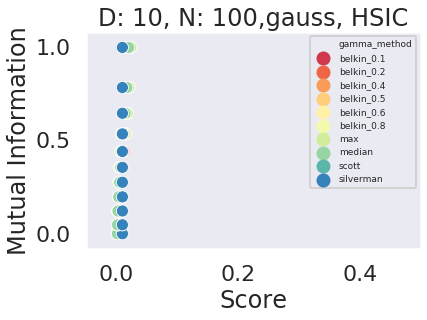

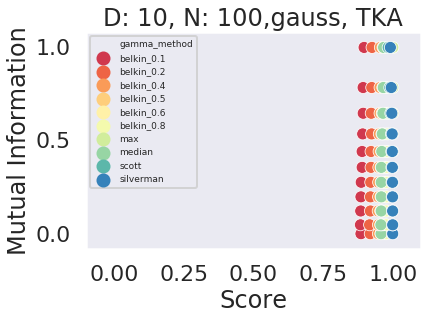

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


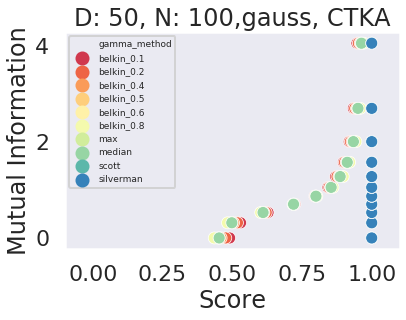

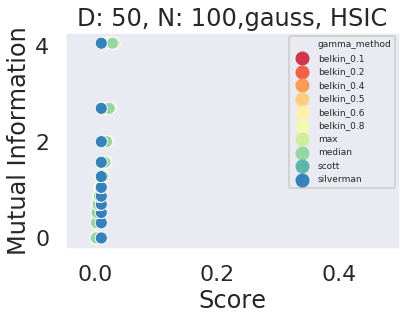

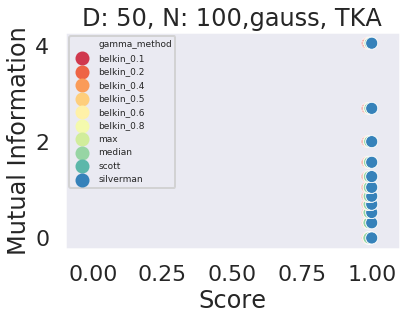

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


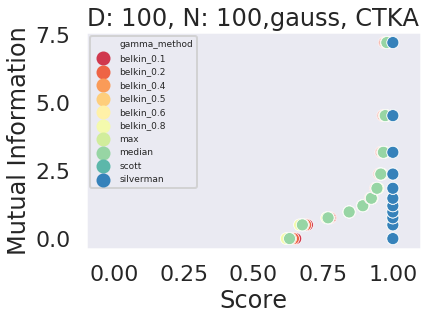

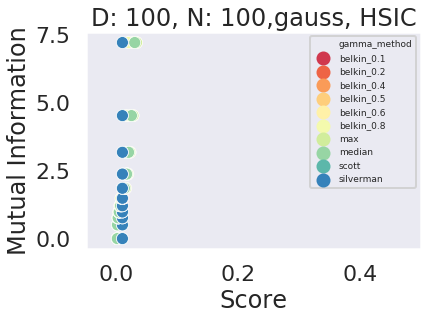

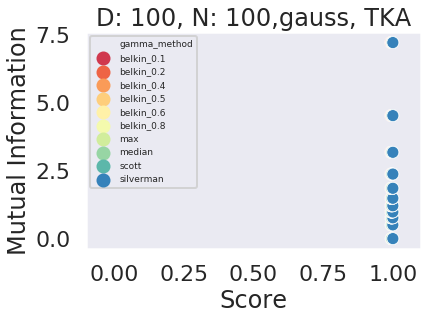

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


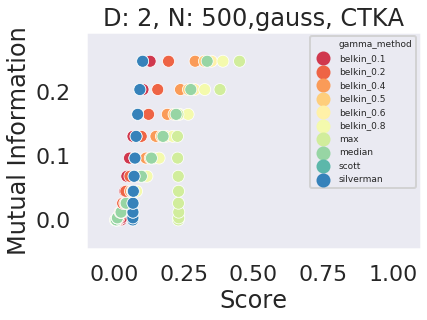

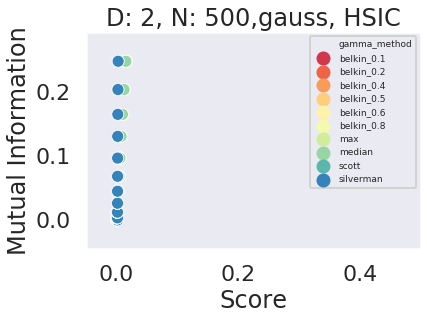

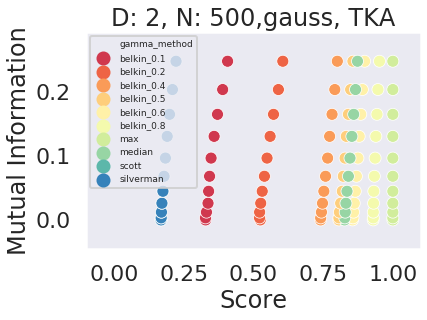

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


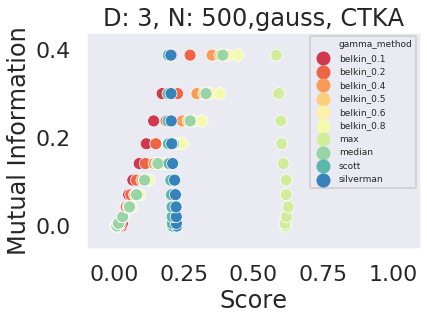

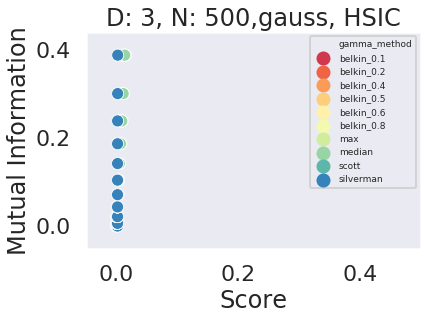

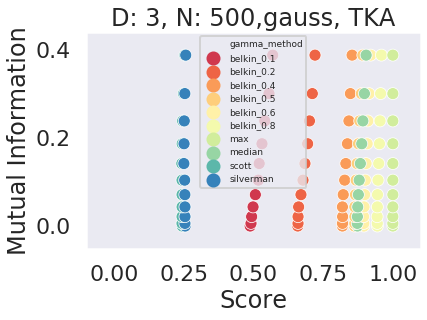

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


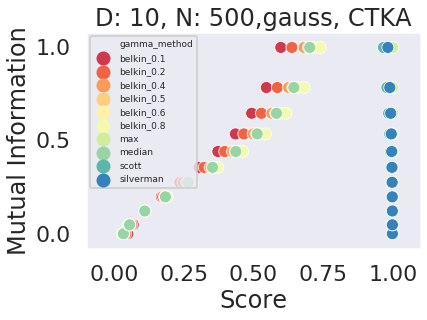

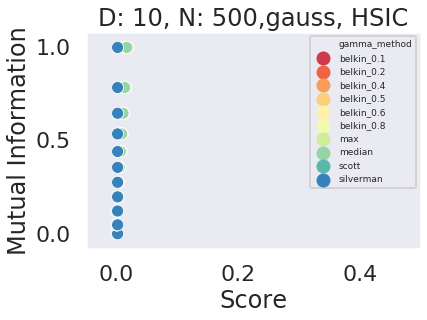

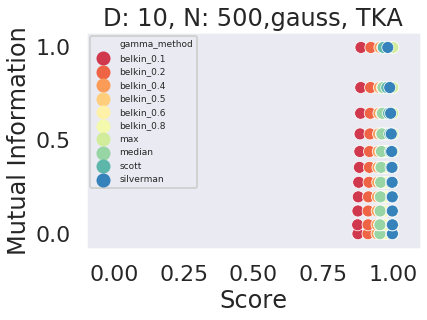

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


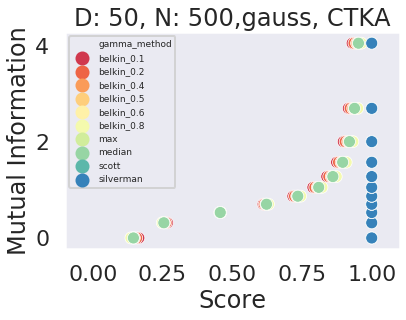

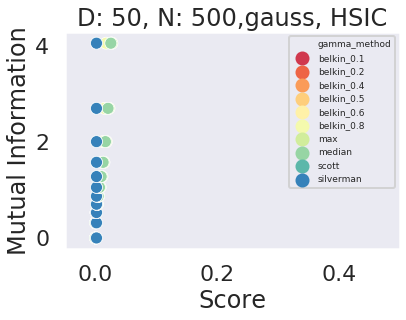

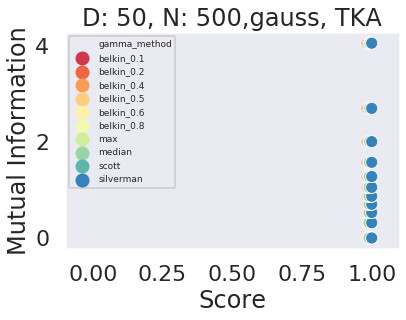

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


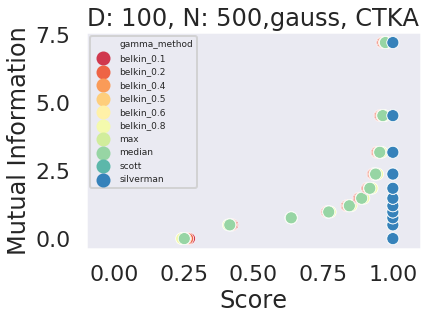

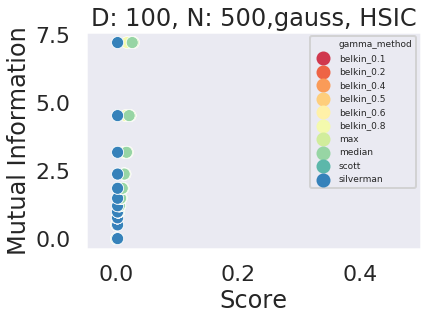

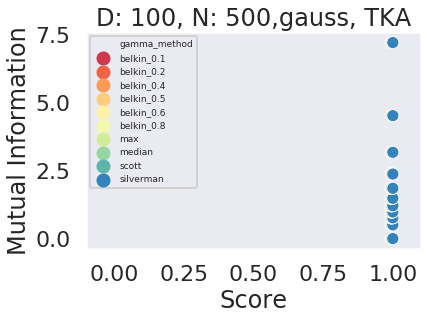

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


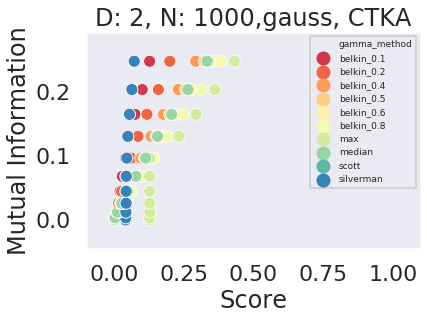

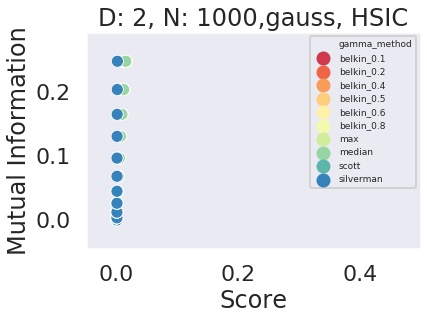

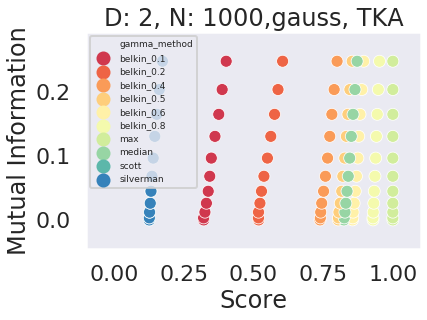

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


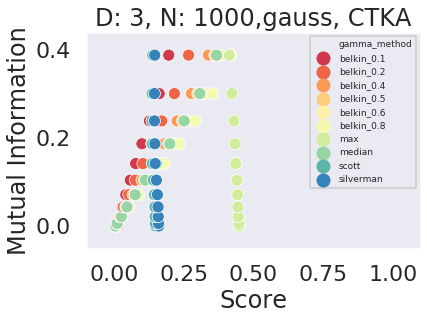

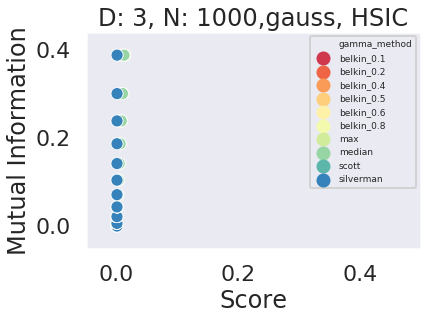

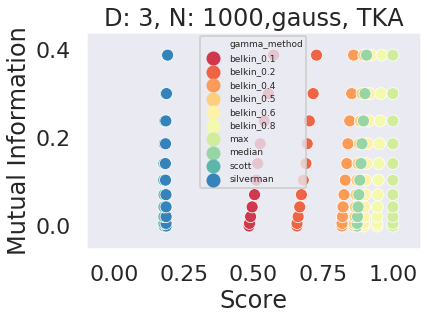

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


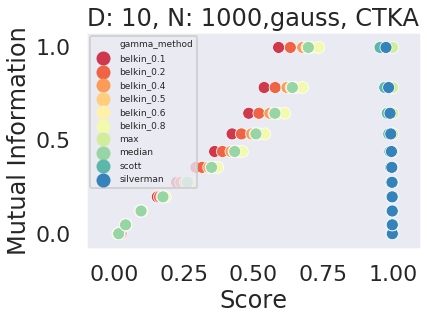

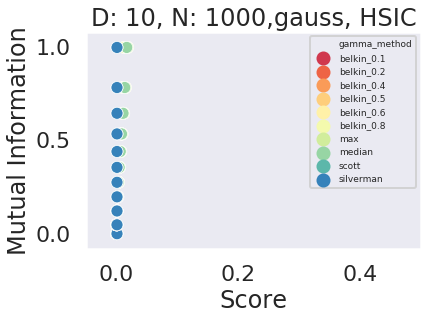

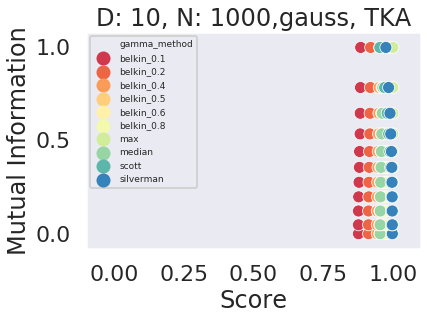

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


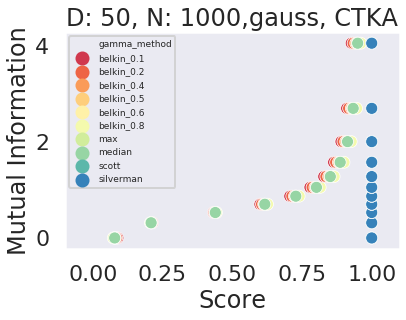

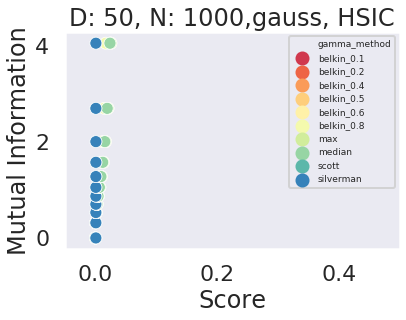

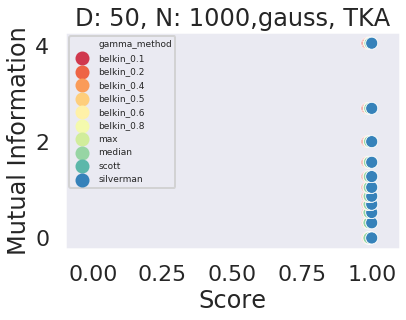

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


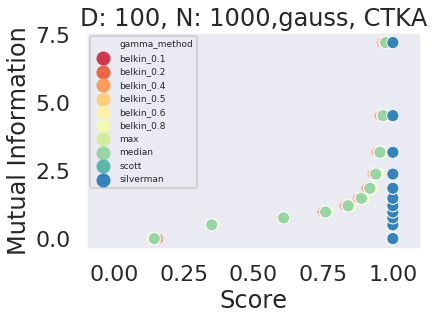

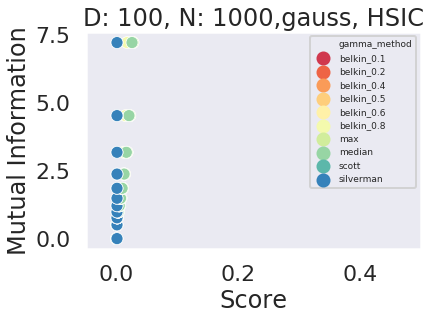

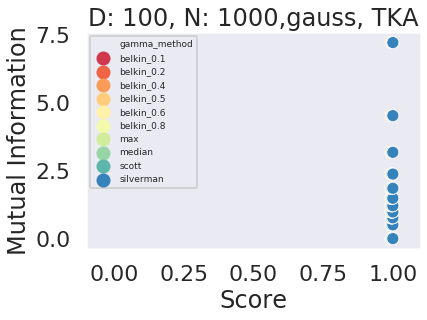

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


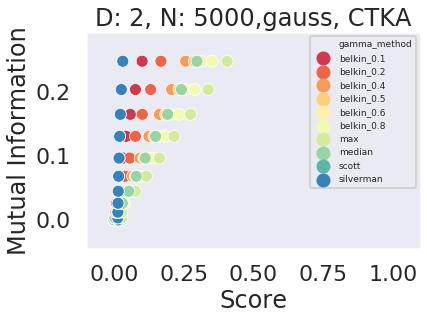

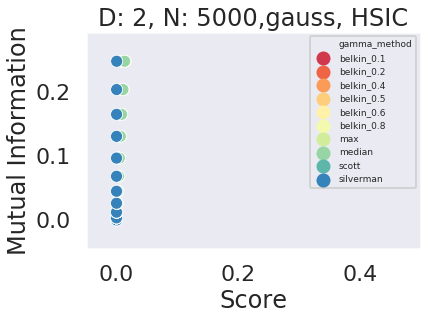

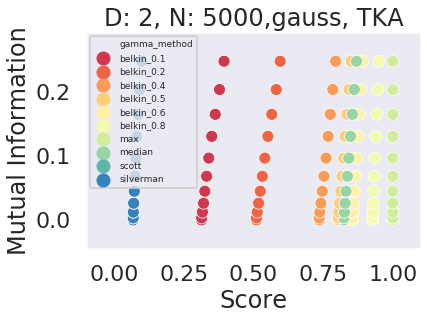

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


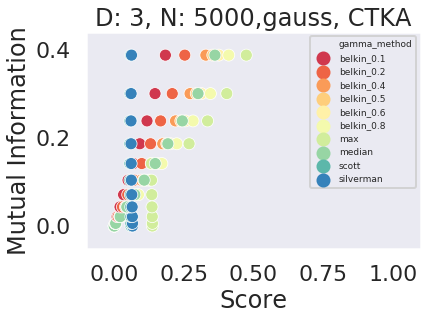

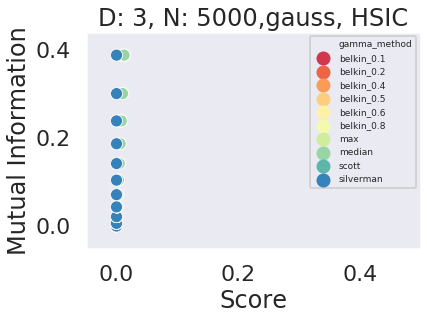

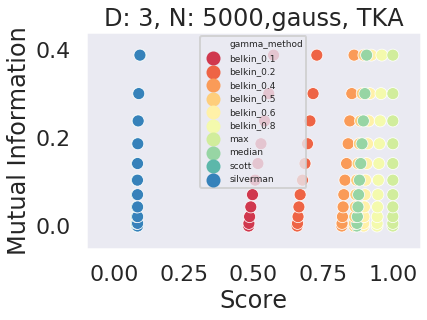

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


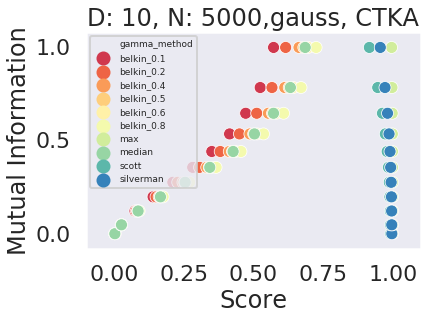

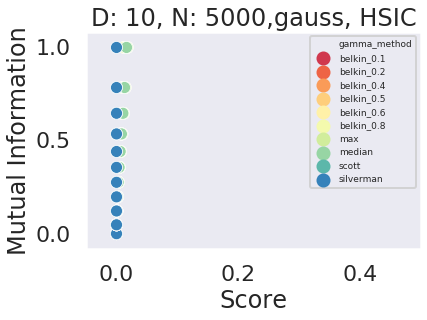

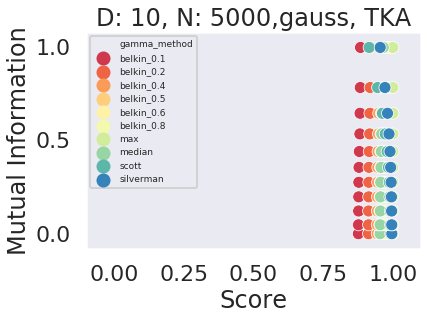

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


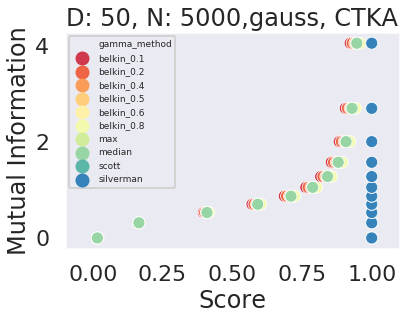

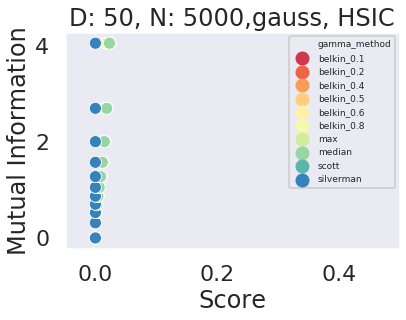

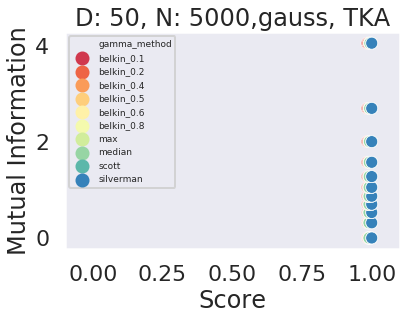

['silverman' 'scott' 'median' 'belkin_0.1' 'belkin_0.2' 'belkin_0.4'
 'belkin_0.5' 'belkin_0.6' 'belkin_0.8' 'max']


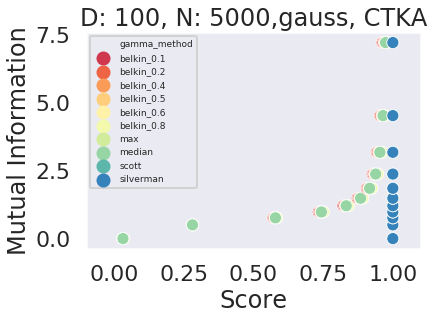

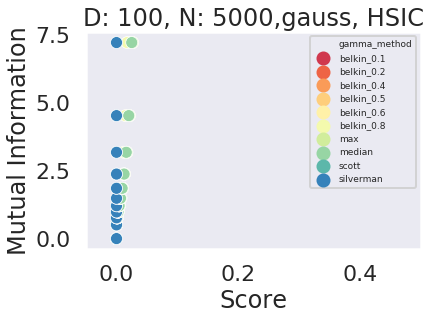

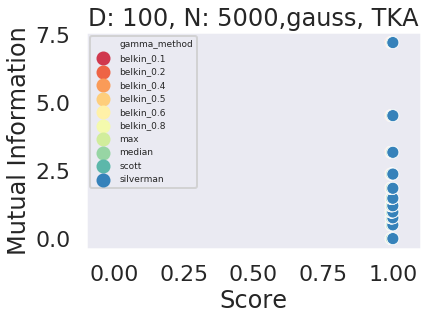

In [11]:
plot_groups = ['dataset', 'samples', 'dimensions', ]

subres =  results_gaussian.groupby(plot_groups)

for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare(igroup[1])
    print(fixed_vars['gamma_method'])
    t = igroup
#     print(t.head())
    plot_gammas(igroup, fixed_vars, save=True)
#     break

## Figure I - T-Student Distribution

This first figure is to demonstrate how the mutual information compares with the amount of noise for each of the functions **Linear**, **Sinusoidal**, **Circular**, and **Random**.

In [23]:
results_gaussian = results_df[results_df['dataset'] == 'gauss']
results_tstudent = results_df[results_df['dataset'] == 'tstudent']


results_tstudent.head()

dataset  trial  samples  dimensions  dof gamma_method  gamma_init scorer  \
0  tstudent    1.0     50.0         2.0  1.0    silverman    1.842016   hsic   
1  tstudent    1.0     50.0         2.0  2.0    silverman    1.842016   hsic   
2  tstudent    1.0     50.0         2.0  3.0    silverman    1.842016   hsic   
3  tstudent    1.0     50.0         2.0  4.0    silverman    1.842016   hsic   
4  tstudent    1.0     50.0         2.0  5.0    silverman    1.842016   hsic   

   hsic_value  mi_value  
0    0.019911  0.302042  
1    0.018461  0.136519  
2    0.017661  0.079458  
3    0.017227  0.052638  
4    0.016863  0.037823

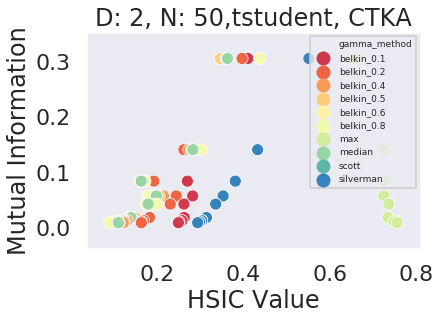

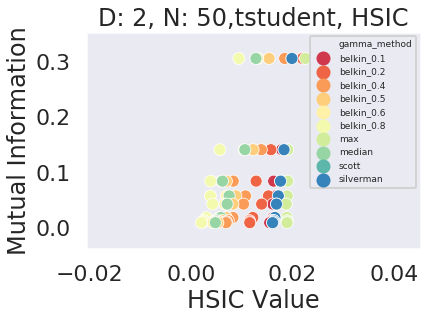

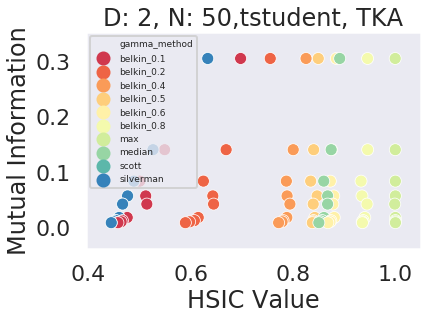

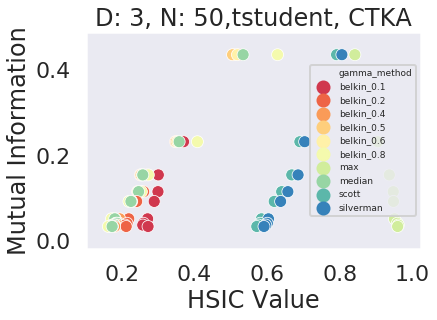

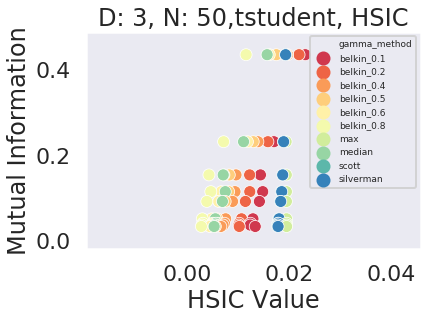

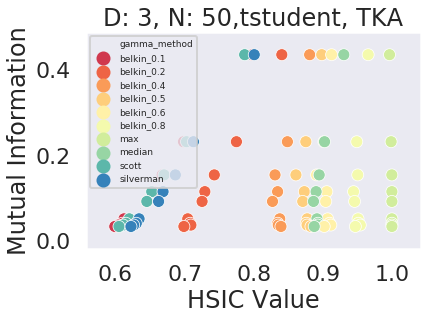

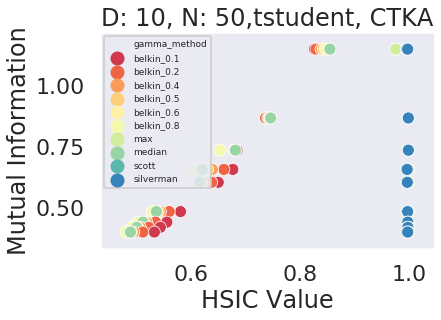

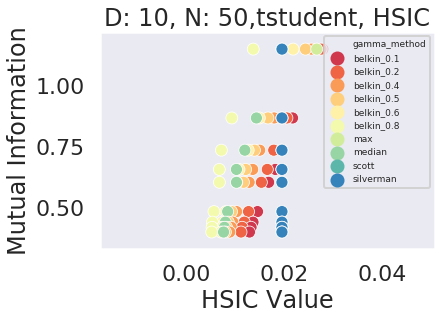

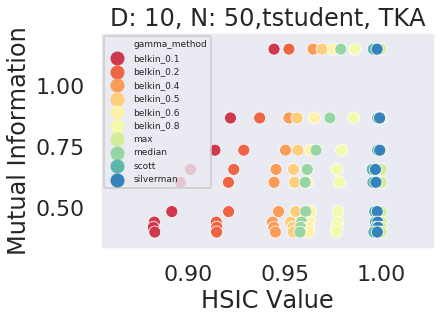

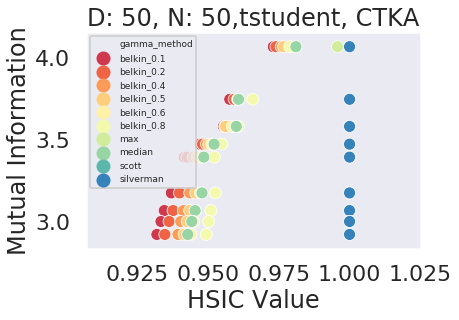

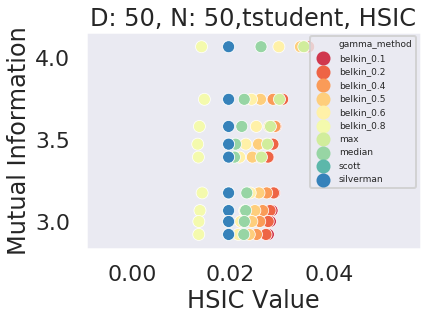

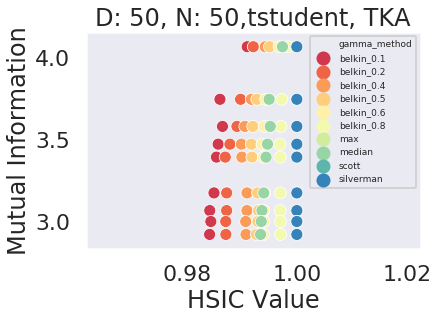

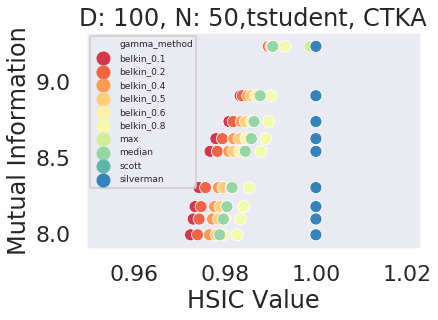

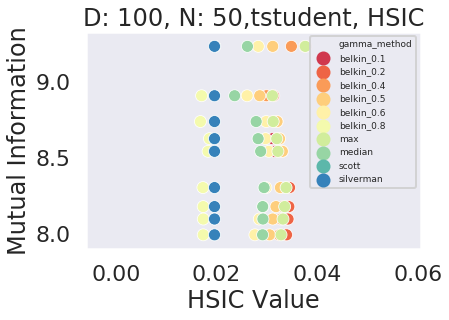

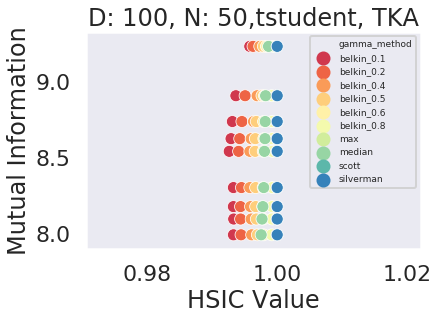

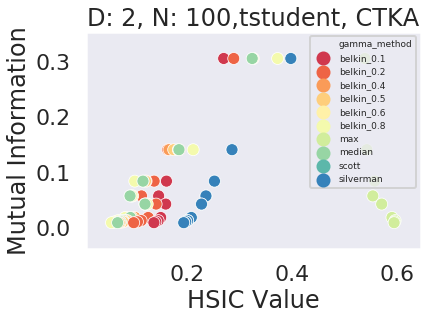

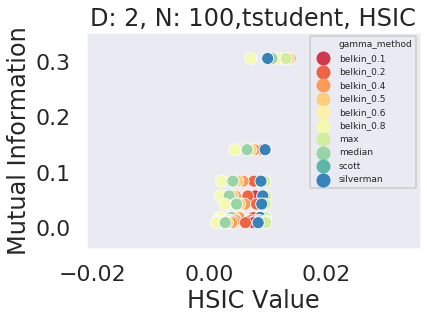

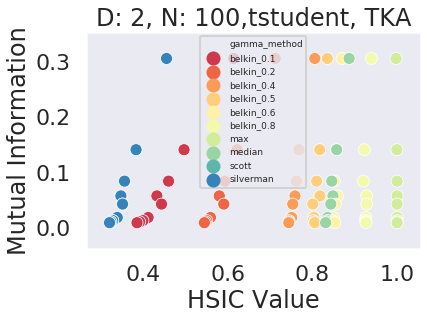

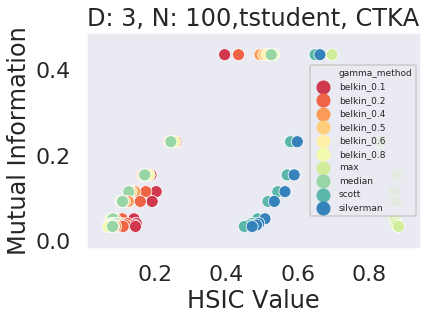

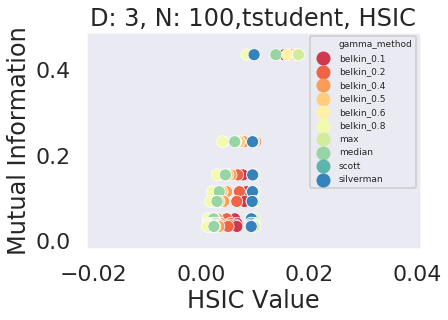

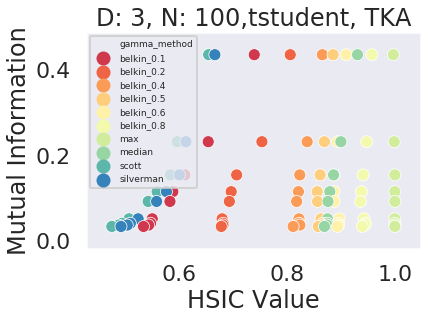

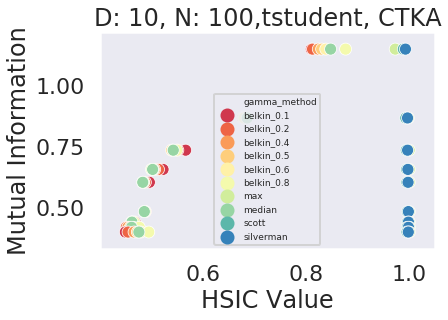

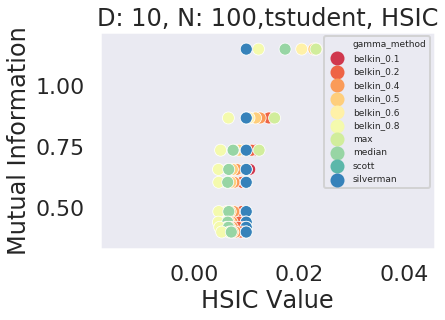

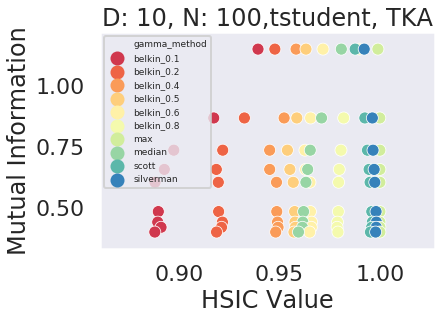

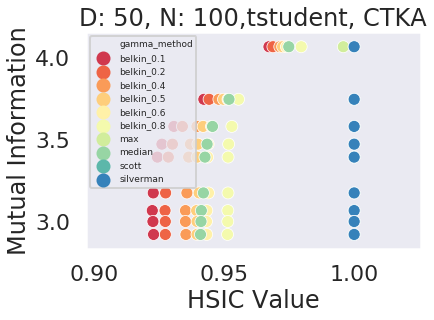

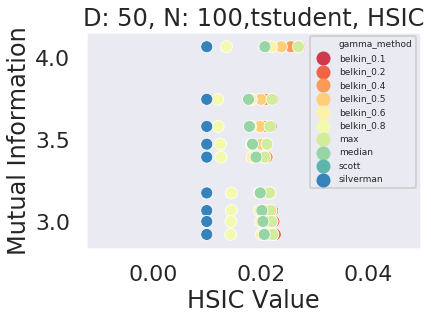

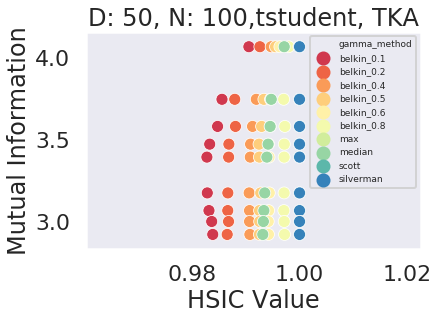

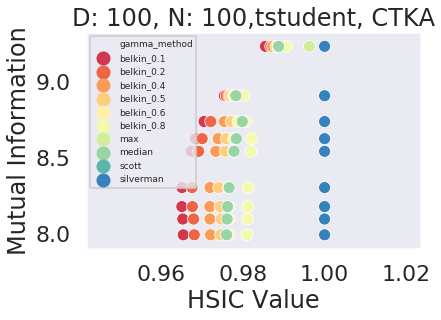

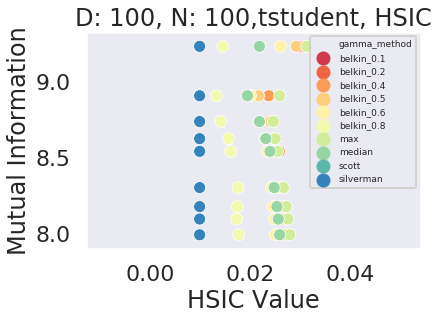

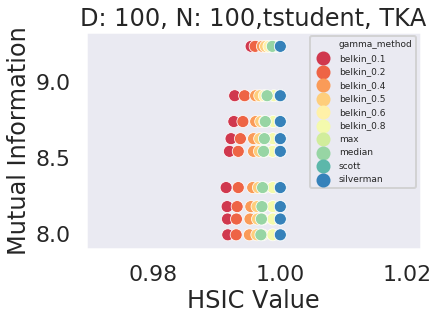

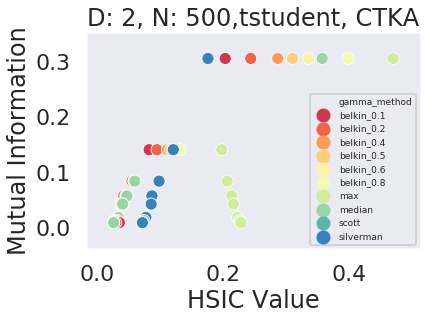

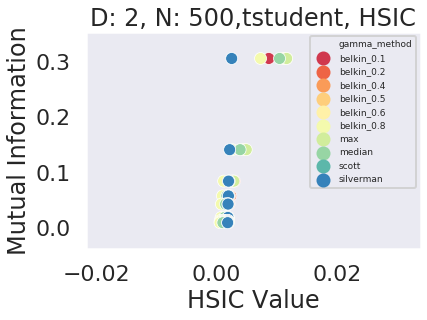

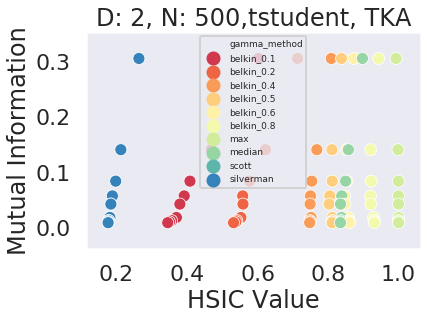

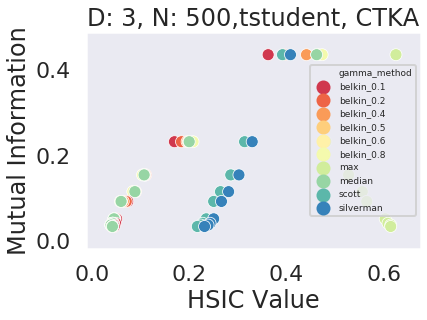

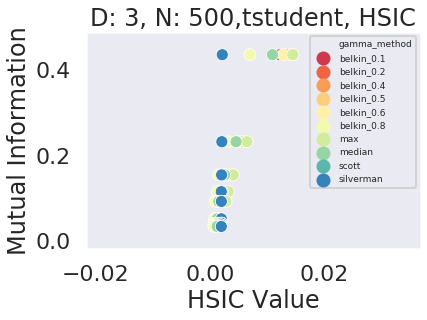

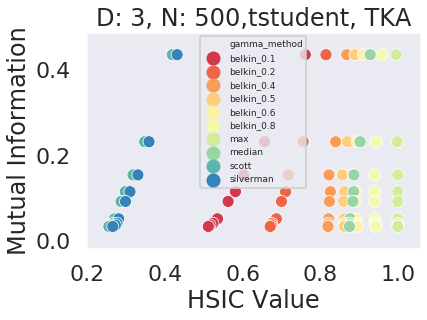

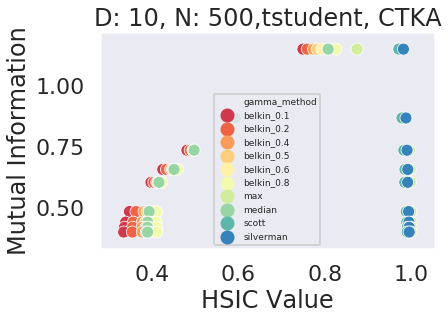

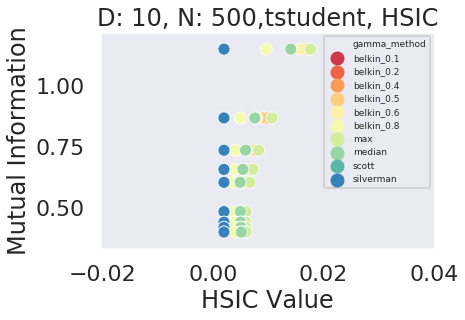

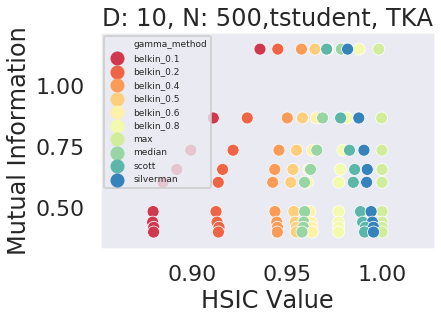

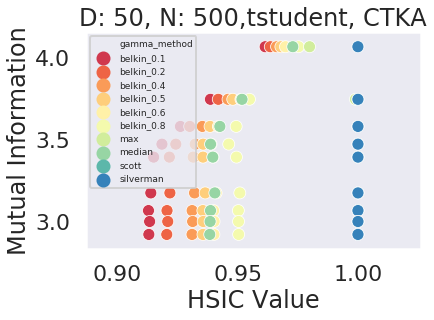

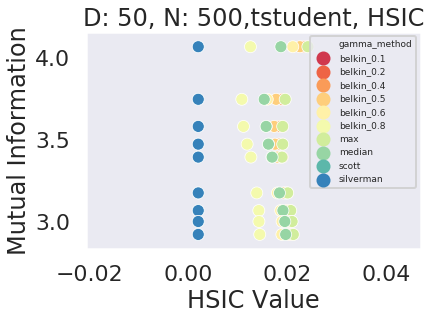

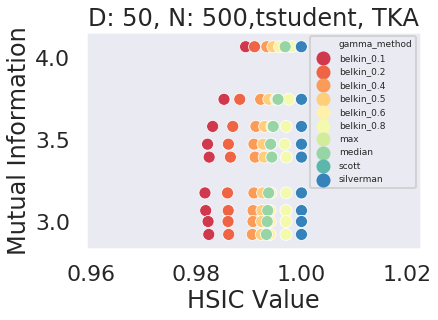

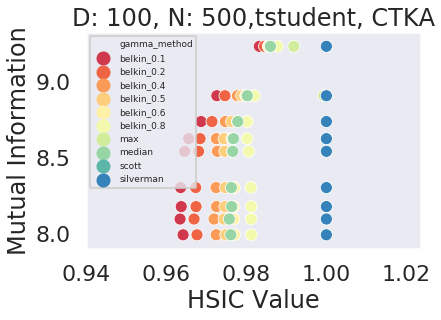

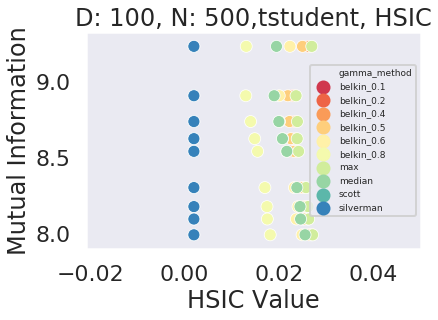

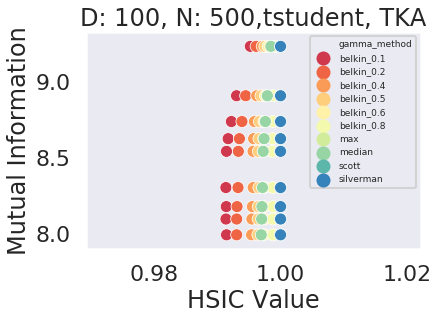

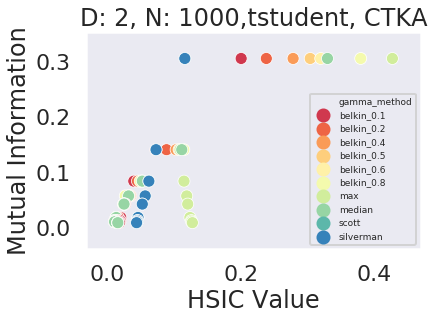

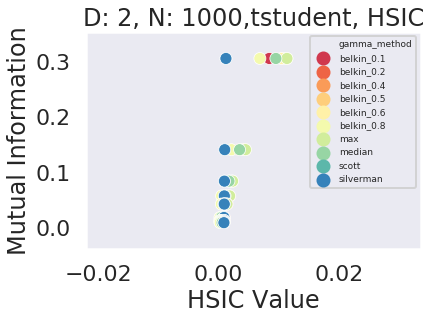

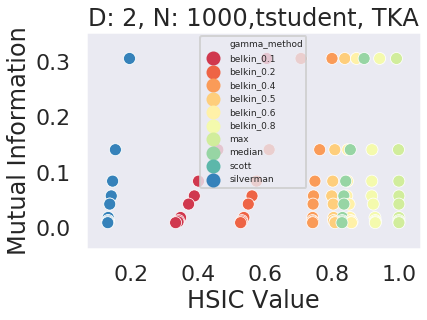

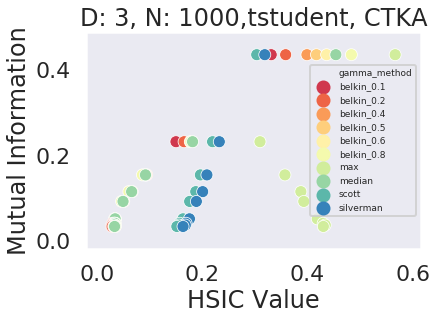

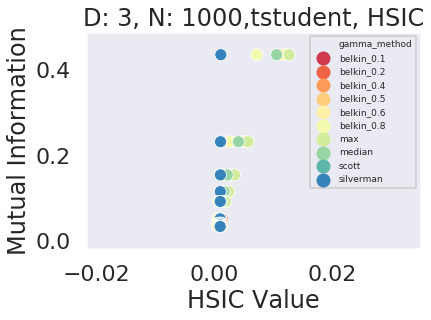

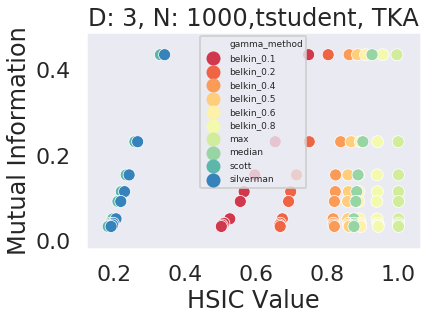

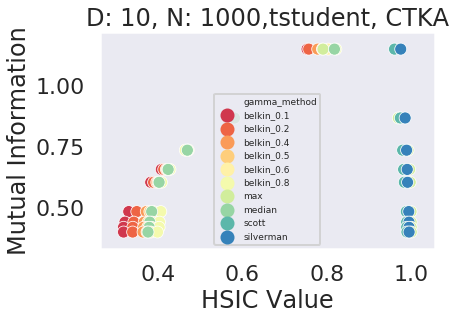

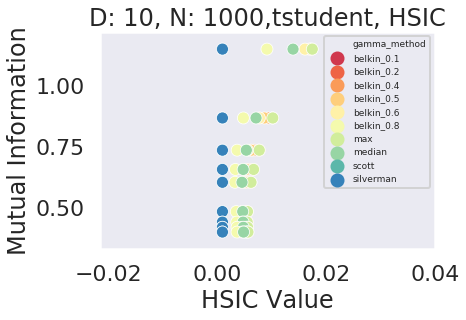

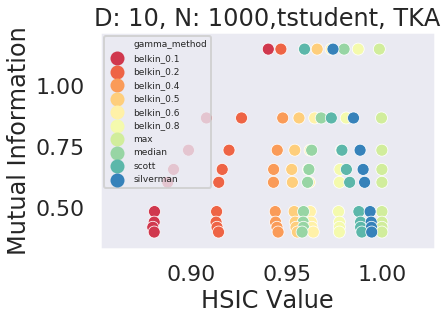

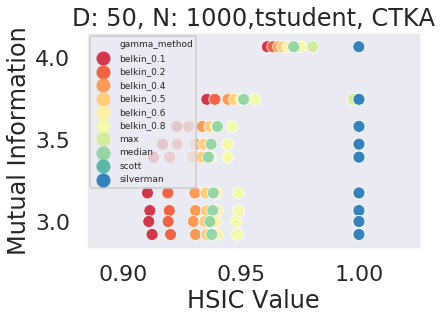

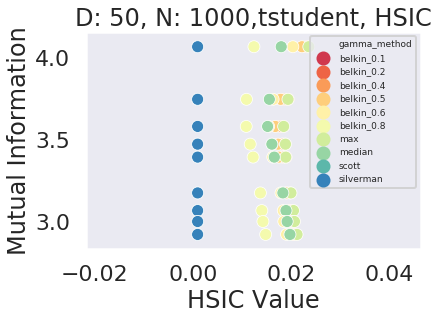

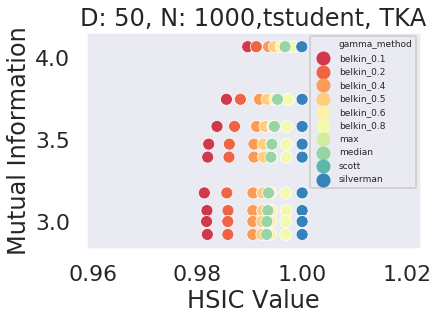

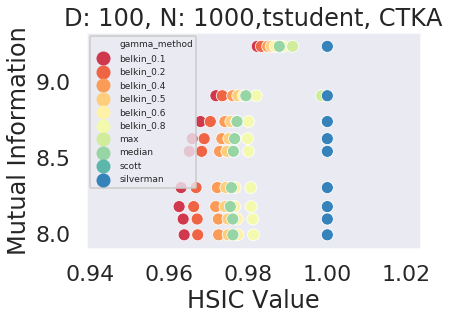

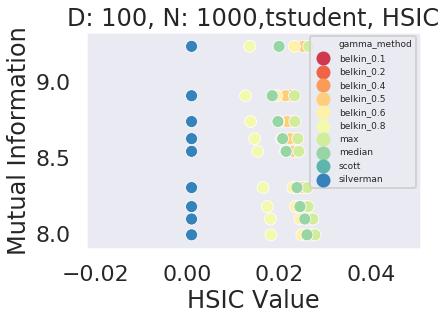

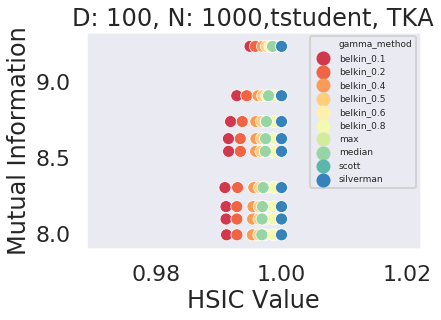

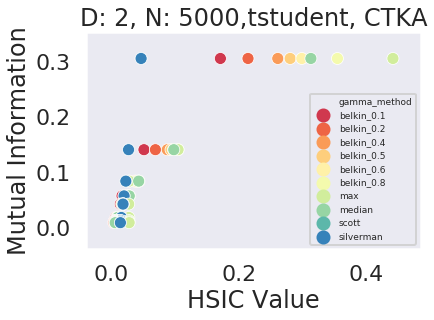

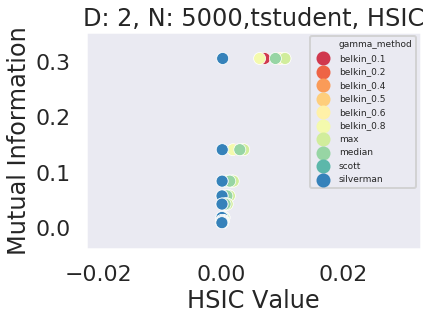

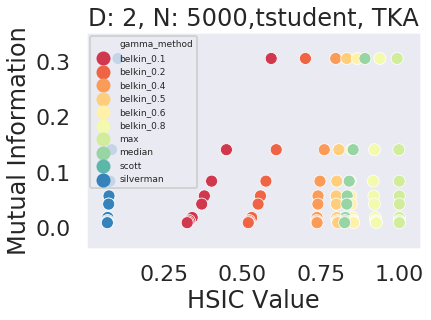

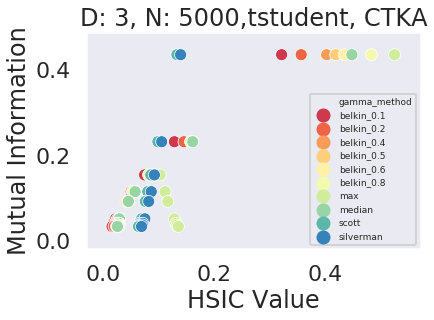

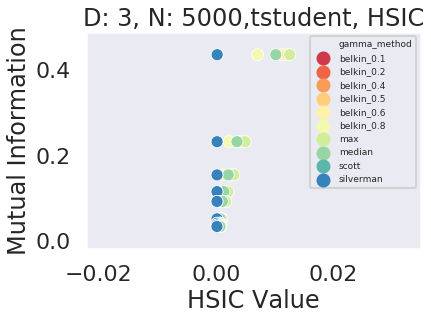

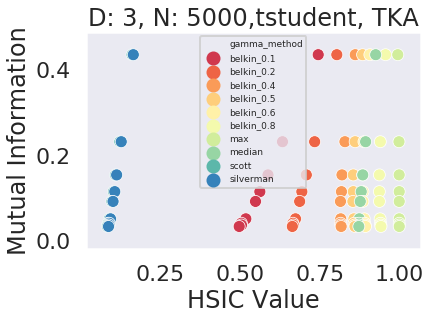

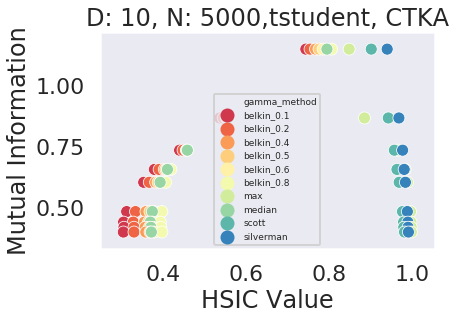

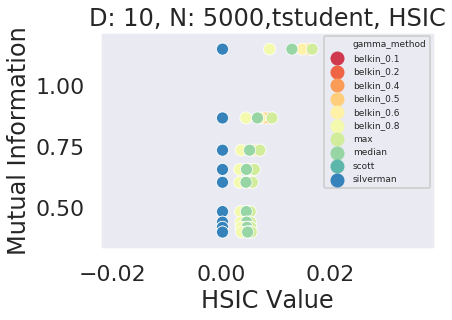

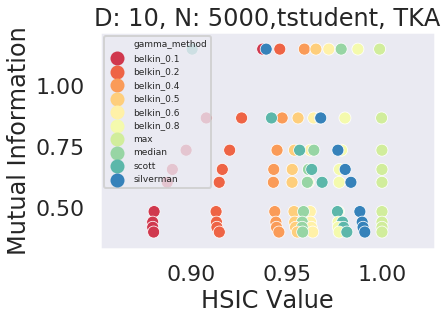

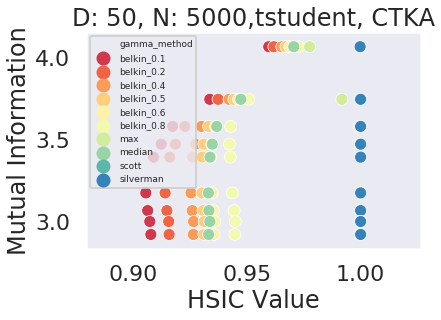

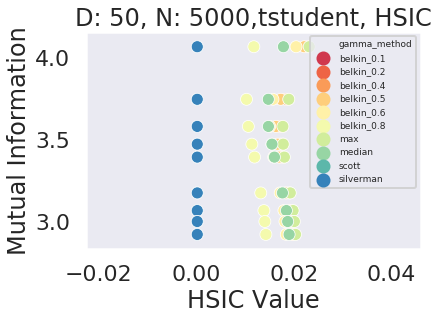

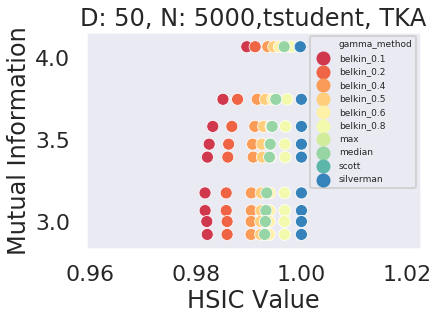

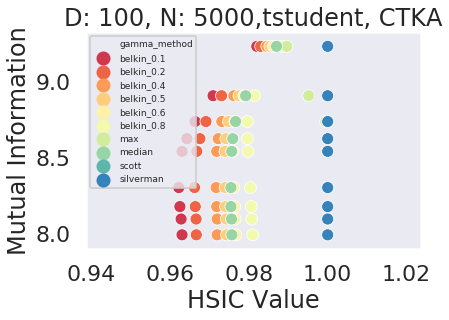

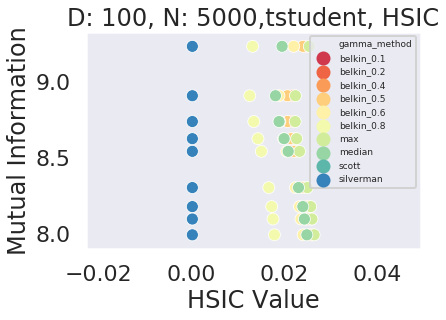

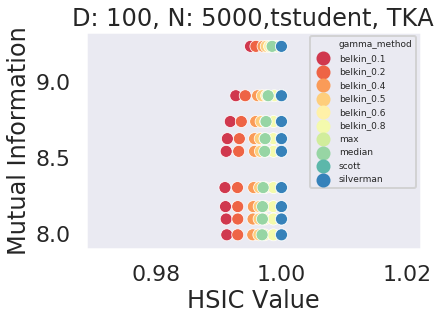

In [26]:
plot_groups = ['dataset', 'samples', 'dimensions', ]

subres =  results_tstudent.groupby(plot_groups)

for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare(igroup[1])
    
    t = igroup

    plot_gammas(igroup, fixed_vars, save=True)


In [4]:
def plot_prepare_all(res_df, dataset='gauss'):
    
    # grab dataset attributes (fixed variables)
    dataset = res_df['dataset'].unique()  
    gamma_init = res_df['gamma_method'].unique()
    scorers = res_df['scorer'].unique().tolist()
    fixed_vars = {
        'gamma_method': gamma_init,
        'dataset': dataset,
        'scorer': scorers,
    }

    return res_df, fixed_vars

In [5]:
def plot_all(res_df, fixed_vars, save=True, drop=None, subset=None):
    for iscore in res_df.groupby('scorer'):
        
#         print(iscore[1].head())
        
        # Drop unnecessary columns
        mean_results = iscore[1].groupby(['mi_value', 'gamma_method']).median()
        std_results = iscore[1].groupby(['mi_value', 'gamma_method']).std()
#         print(mean_results.head(3))
        mean_results = mean_results.reset_index().drop(columns=[ 'trial', 'samples', 'dimensions', 'dof'])
        gamma_legend = mean_results['gamma_method'].unique()
        
        # Transform the mi_scores
        mean_results['mi_value'] += 1 #np.log2(mean_results['mi_score']+1)
        if subset is not None:
            mean_results = mean_results[mean_results['gamma_method'].isin(subset)]
        if drop is not None:
            mean_results = mean_results[~mean_results['gamma_method'].isin(drop)]
#         print(mean_results.head(3))
        
#         print(mean_results.head(3))
#         break
#         print(mean_results.head())
        fig, ax = plt.subplots()
        pts = sns.scatterplot(
            x='hsic_value', 
            y='mi_value', 
            hue='gamma_method',
            data=mean_results, 
#             size='hsic_std',
#             sizes=(50,200),
            legend='brief',
            ax=ax, 
#             hue='gamma', 
#             hue_norm=matplotlib.colors.LogNorm(),
#             label=iscore[0].upper(),
            palette='Spectral'
        )
        ax.legend(prop={'size':9})
        ax.set_yscale('log')
        ax.set_xlabel('Score')
        ax.set_ylabel(r'Mutual Information')
        ax.set_title(
            f"{fixed_vars['dataset'][0]}, "
            f"{iscore[0].upper()}"
        )
        
        # COLORBAR
#         norm = matplotlib.colors.LogNorm(mean_results.gamma.min(), mean_results.gamma.max())
#         sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
#         sm.set_array([])
#         pts.figure.colorbar(sm, label=r'RBF Bandwidth, $\gamma$')
        
        plt.show()
        if save:
            save_name = \
                f"{fixed_vars['dataset'][0]}_" + \
                f"{iscore[0].upper()}" + \
                ".png"

            fig.savefig(fig_path + save_name)
    return None

In [6]:
t.tail()

NameError: name 't' is not defined

In [ ]:
plt.style.available

### Plot Everything Together - Colors: Gamma Method

##### Standard Methods: Median, Silverman, Scott, Max

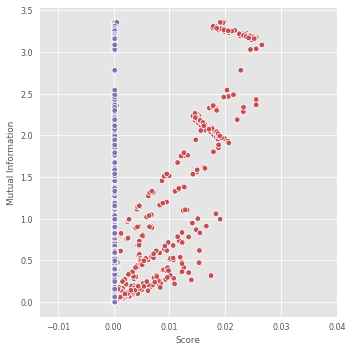

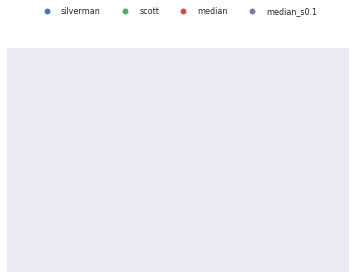

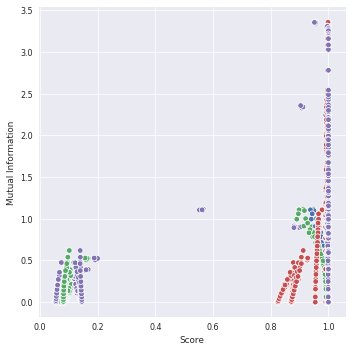

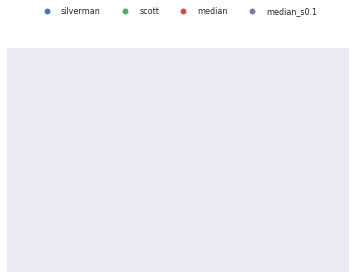

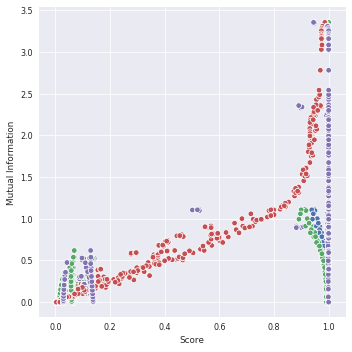

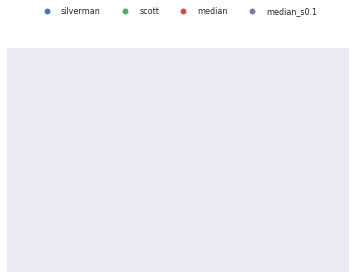

In [37]:
plot_scorer_mi(
    results_df, 'hsic', None, 
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
#         'silverman', 
#         'scott', 
        'median_p0.2', 
        'median_p0.4',
        'median_p0.6',
        'median_p0.8',
#         'max', 
        'median_s0.01', 
        'median_s0.11',
        'median_s10',
        'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)
plot_scorer_mi(
    results_df, 'tka', None,  
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
#         'silverman', 
#         'scott', 
        'median_p0.2', 
        'median_p0.4',
        'median_p0.6',
        'median_p0.8',
#         'max', 
        'median_s0.01', 
        'median_s0.11',
        'median_s10',
        'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)
plot_scorer_mi(
    results_df, 'ctka', None, 
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
#         'silverman', 
#         'scott', 
        'median_p0.2', 
        'median_p0.4',
        'median_p0.6',
        'median_p0.8',
#         'max', 
        'median_s0.01', 
        'median_s0.11',
        'median_s10',
        'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)

##### Median Percent Methods

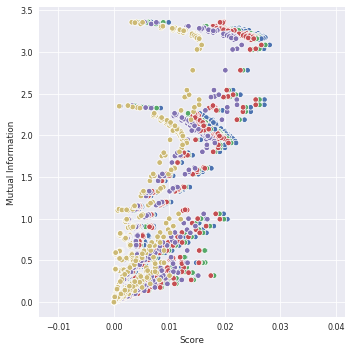

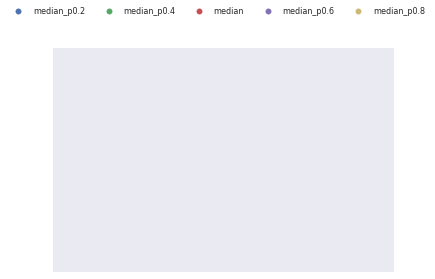

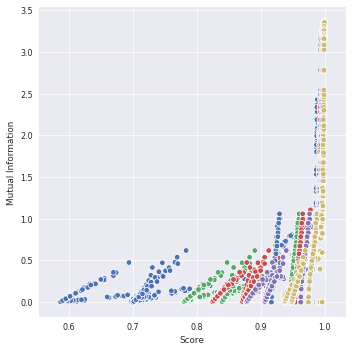

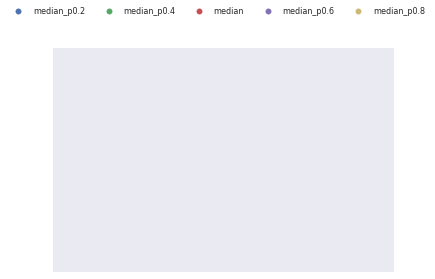

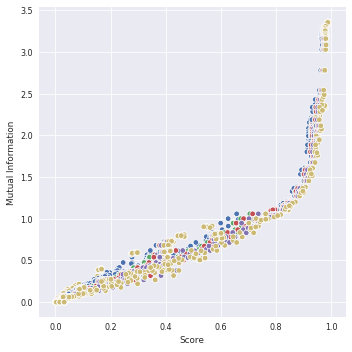

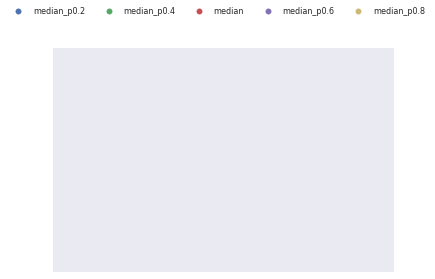

In [10]:
plot_scorer_mi(
    results_df, 'hsic', None, 
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
        'silverman', 
        'scott', 
#         'median_p0.2', 
#         'median_p0.4',
#         'median_p0.6',
#         'median_p0.8',
        'max', 
        'median_s0.01', 
        'median_s0.1',
        'median_s10',
        'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)
plot_scorer_mi(
    results_df, 'tka', None,  
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
        'silverman', 
        'scott', 
#         'median_p0.2', 
#         'median_p0.4',
#         'median_p0.6',
#         'median_p0.8',
        'max', 
        'median_s0.01', 
        'median_s0.1',
        'median_s10',
        'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)
plot_scorer_mi(
    results_df, 'ctka', None, 
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
        'silverman', 
        'scott', 
#         'median_p0.2', 
#         'median_p0.4',
#         'median_p0.6',
#         'median_p0.8',
        'max', 
        'median_s0.01', 
        'median_s0.1',
        'median_s10',
        'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)

##### Median Scale

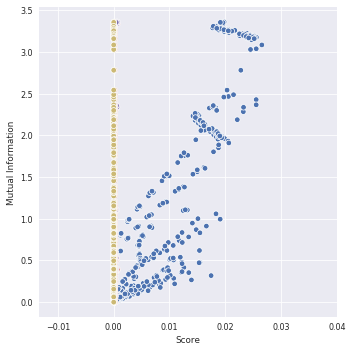

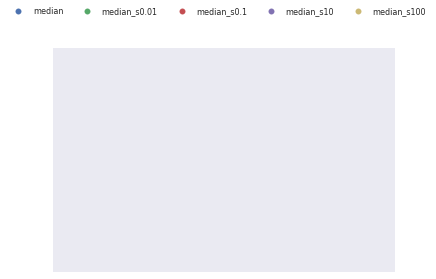

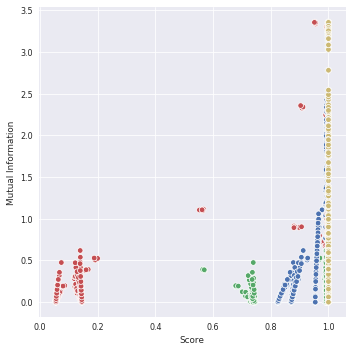

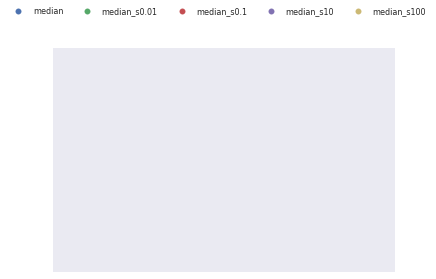

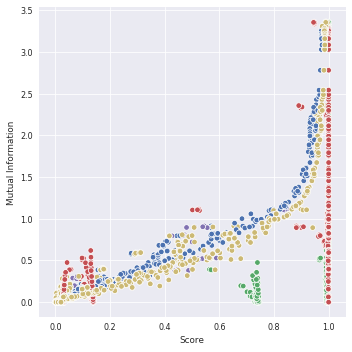

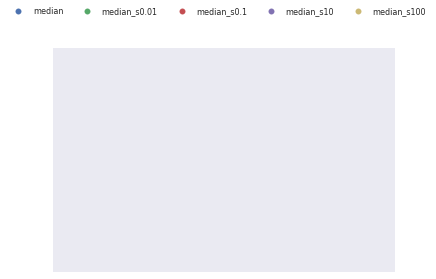

In [40]:
plot_scorer_mi(
    results_df, 'hsic', None, 
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
        'silverman', 
        'scott', 
        'median_p0.2', 
        'median_p0.4',
        'median_p0.6',
        'median_p0.8',
        'max', 
#         'median_s0.01', 
#         'median_s0.11',
#         'median_s10',
#         'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)
plot_scorer_mi(
    results_df, 'tka', None,  
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
        'silverman', 
        'scott', 
        'median_p0.2', 
        'median_p0.4',
        'median_p0.6',
        'median_p0.8',
        'max', 
#         'median_s0.01', 
#         'median_s0.11',
#         'median_s10',
#         'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)
plot_scorer_mi(
    results_df, 'ctka', None, 
    hue='gamma_method',
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
        'silverman', 
        'scott', 
        'median_p0.2', 
        'median_p0.4',
        'median_p0.6',
        'median_p0.8',
        'max', 
#         'median_s0.01', 
#         'median_s0.11',
#         'median_s10',
#         'median_s100',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
    plot_legend=True
)

### Plot Everything Together - Colors: Distribution

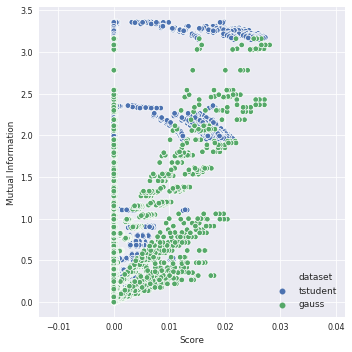

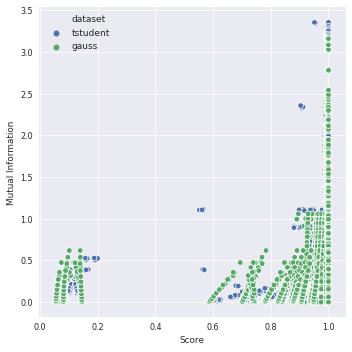

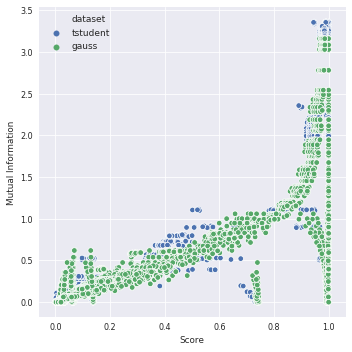

In [24]:
plot_scorer_mi(
    results_df, 
    scorer='hsic', 
    hue='dataset',
    dataset=None, 
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
#         'silverman', 
#         'scott', 
#         'belkin_0.1', 
#         'max', 
#         'belkin_0.2', 
#         'belkin_0.5',
#         'belkin_0.4',
#         'belkin_0.6',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)

plot_scorer_mi(
    results_df, 
    scorer='tka', 
    hue='dataset',
    dataset=None, 
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
#         'silverman', 
#         'scott', 
#         'belkin_0.1', 
#         'max', 
#         'belkin_0.2', 
#         'belkin_0.5',
#         'belkin_0.4',
#         'belkin_0.6',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)

plot_scorer_mi(
    results_df, 
    scorer='ctka', 
    hue='dataset',
    dataset=None, 
    omit_samples=('samples', ['50', '100', '500', '1000']),
    omit_methods=('gamma_method', [
#         'median',
#         'silverman', 
#         'scott', 
#         'belkin_0.1', 
#         'max', 
#         'belkin_0.2', 
#         'belkin_0.5',
#         'belkin_0.4',
#         'belkin_0.6',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)

### Plot Individual

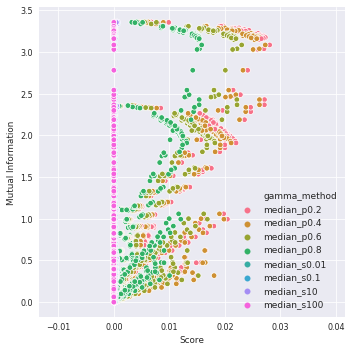

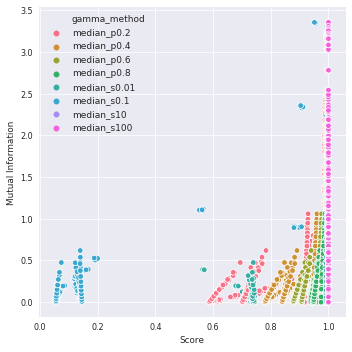

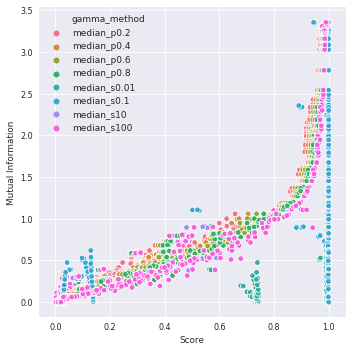

In [8]:
plot_scorer_mi(
    results_df, 'hsic', None, 
    ('samples', ['50', '100', '500', '1000']),
    ('gamma_method', [
        'median',
        'silverman', 
        'scott', 
        'belkin_0.1', 
        'max', 
        'belkin_0.2', 
        'belkin_0.5',
        'belkin_0.4',
        'belkin_0.6',
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)
plot_scorer_mi(
    results_df, 'tka', None, 
    ('samples', ['50', '100', '500', '1000']),
    ('gamma_method', [
        'median',
        'silverman', 
        'scott', 
        'belkin_0.1', 
        'max', 
        'belkin_0.2', 
        'belkin_0.5',
        'belkin_0.4',
        'belkin_0.6'
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
)
plot_scorer_mi(
    results_df, 'ctka', None, 
    ('samples', ['50', '100', '500', '1000']),
    ('gamma_method', [
        'median',
        'silverman', 
        'scott', 
        'belkin_0.1', 
        'max', 
        'belkin_0.2', 
        'belkin_0.5',
        'belkin_0.4',
        'belkin_0.6'
    ]),
    style=['seaborn', 'seaborn-paper'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)

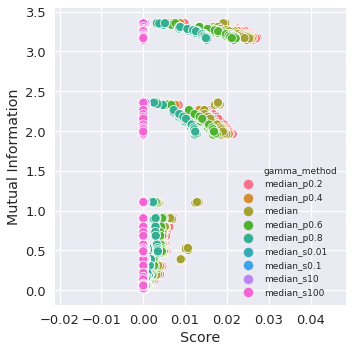

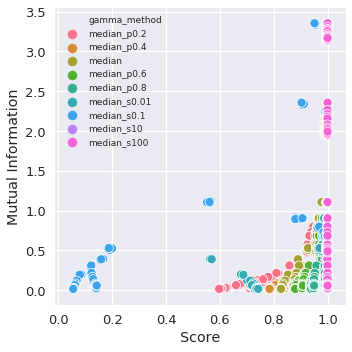

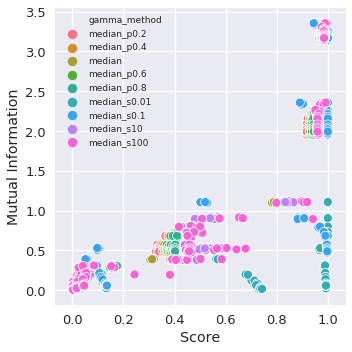

In [10]:
plot_scorer_mi(
    results_df, 'hsic', 'tstudent', 
    ('samples', ['50', '100', '500', '1000']),
    ('gamma_method', ['silverman', 'scott', 'belkin_0.1', 'belkin_0.5']),
    style=['seaborn', 'seaborn-talk'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)
plot_scorer_mi(
    results_df, 'tka', 'tstudent', 
    ('samples', ['50', '100', '500', '1000']),
    ('gamma_method', ['max', 'silverman', 'scott', 'belkin_0.1', 'belkin_0.5']),
    style=['seaborn', 'seaborn-talk'],
    log_mi=True,
    log_score=False,
    save=True,
    title='',
)
plot_scorer_mi(
    results_df, 'ctka', 'tstudent', 
    ('samples', ['50', '100', '500', '1000']),
    ('gamma_method', ['max', 'silverman', 'scott', 'belkin_0.1', 'belkin_0.5']),
    style=['seaborn', 'seaborn-talk'],
    log_mi=True,
    log_score=False,
    save=True,
    title=''
)

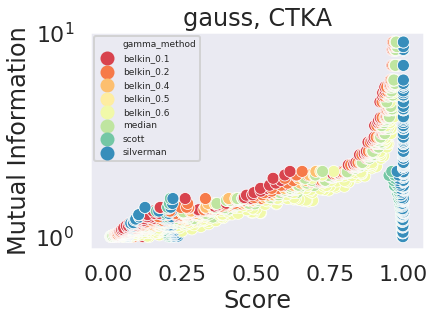

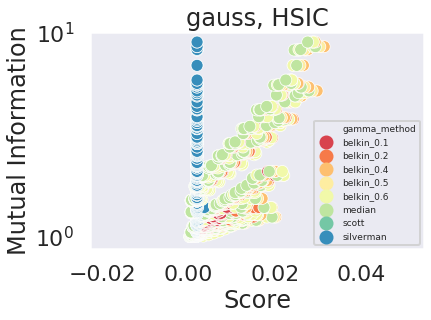

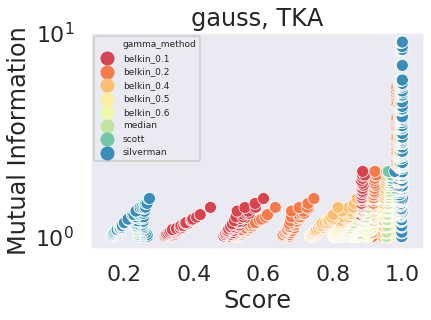

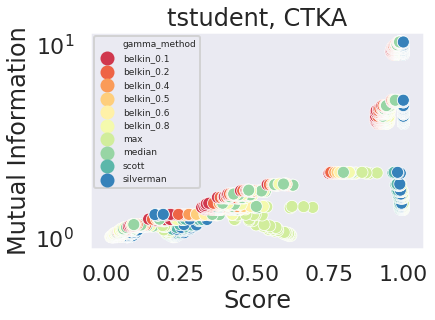

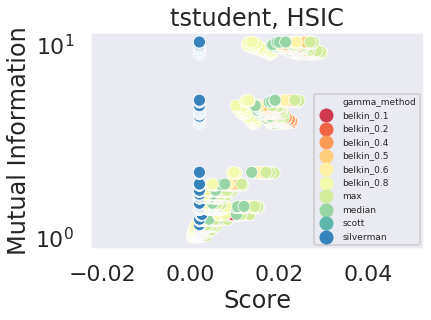

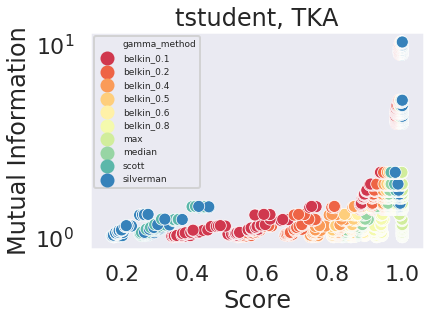

In [80]:
plot_groups = ['dataset', ]

subres =  results_df.groupby(plot_groups)

for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare_all(igroup[1])
    
    t = igroup
    plot_all(igroup, fixed_vars, save=False, drop=None, subset=None)
#     break